In [15]:
# Install required packages
%pip install minisom tensorflow pennylane qiskit gym

Note: you may need to restart the kernel to use updated packages.


In [16]:
# This code compares path optimization methods for autonomous drone navigation
# using a synthetic environment. We simulate four methods:
# 1. The new method (SOM + QAOA + RL) [Simulated with clustering + simulated quantum optimization + RL adjustment]
# 2. A* algorithm
# 3. Dijkstra's algorithm
# 4. Genetic Algorithm (GA) for TSP

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from sklearn.cluster import KMeans

# For GA, we implement a simple TSP GA solver

import random

# Synthetic environment: create waypoints randomly and define obstacles as circles
np.random.seed(42)
num_waypoints = 20
waypoints = np.random.rand(num_waypoints, 2) * 100

# Define obstacles: center and radius. We'll mark a few circular obstacles
obstacles = [((30, 30), 10), ((70, 70), 12), ((50, 20), 8)]


def plot_environment(ax, path=None, title=''):
    ax.clear()
    # plot waypoints
    ax.scatter(waypoints[:,0], waypoints[:,1], c='blue', label='Waypoints')
    # plot obstacles
    for center, r in obstacles:
        circle = plt.Circle(center, r, color='red', alpha=0.3)
        ax.add_patch(circle)
    # plot path if provided
    if path is not None:
        path = np.array(path)
        ax.plot(path[:,0], path[:,1], c='green', marker='o', label='Path')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)


def distance(p, q):
    return np.linalg.norm(np.array(p)-np.array(q))

# A* and Dijkstra implementations on fully connected graph, but avoid obstacles
# For simplicity, we build a weighted graph using euclidean distances and then remove edges that cross obstacles

def edge_crosses_obstacle(p, q):
    # Check edge p->q if it crosses an obstacle (approx using midpoint distance)
    mid = ((p[0]+q[0])/2, (p[1]+q[1])/2)
    for center, r in obstacles:
        if distance(mid, center) < r:
            return True
    return False

# Build graph (fully connecting waypoints not blocked by obstacles)
G = nx.Graph()
for i in range(num_waypoints):
    G.add_node(i, pos=tuple(waypoints[i]))

for i in range(num_waypoints):
    for j in range(i+1, num_waypoints):
        if not edge_crosses_obstacle(waypoints[i], waypoints[j]):
            d = distance(waypoints[i], waypoints[j])
            G.add_edge(i, j, weight=d)

# Choose start and end as the two farthest waypoints for demonstration
max_d = 0
start, end = 0, 0
for i in range(num_waypoints):
    for j in range(i+1, num_waypoints):
        d = distance(waypoints[i], waypoints[j])
        if d > max_d:
            max_d = d
            start, end = i, j

# Standard methods using networkx path algorithms

# A* method with Euclidean heuristic
start_time = time.time()
astar_path_idx = nx.astar_path(G, start, end, heuristic=lambda a, b: distance(G.nodes[a]['pos'], G.nodes[b]['pos']))
astar_time = time.time() - start_time
astar_path = [G.nodes[i]['pos'] for i in astar_path_idx]
astar_length = sum(distance(astar_path[i], astar_path[i+1]) for i in range(len(astar_path)-1))

# Dijkstra
start_time = time.time()
dijkstra_path_idx = nx.dijkstra_path(G, start, end)
dijkstra_time = time.time() - start_time
ndijkstra_path = [G.nodes[i]['pos'] for i in dijkstra_path_idx]
dijkstra_length = sum(distance(ndijkstra_path[i], ndijkstra_path[i+1]) for i in range(len(ndijkstra_path)-1))

# Genetic Algorithm for TSP of all waypoints (we force a tour including start and end fixed)

def tsp_fitness(order):
    # order is the order of waypoint indices including start and end
    total = 0
    for i in range(len(order)-1):
        total += distance(waypoints[order[i]], waypoints[order[i+1]])
    return total

# Initialize population (population of orders that include all waypoints)
population_size = 50
population = []
base_list = list(range(num_waypoints))

for _ in range(population_size):
    perm = base_list.copy()
    random.shuffle(perm)
    population.append(perm)

num_generations = 200
for gen in range(num_generations):
    # Selection
    population = sorted(population, key=lambda x: tsp_fitness(x))
    survivors = population[:10]
    # Crossover and Mutation
    new_population = survivors.copy()
    while len(new_population) < population_size:
        parents = random.sample(survivors, 2)
        # simple ordered crossover
        cut = random.randint(1, num_waypoints-2)
        child = parents[0][:cut] + [gene for gene in parents[1] if gene not in parents[0][:cut]]
        # slight mutation: swap two indices with small probability
        if random.random() < 0.1:
            i, j = random.sample(range(num_waypoints), 2)
            child[i], child[j] = child[j], child[i]
        new_population.append(child)
    population = new_population

ga_best = min(population, key=lambda x: tsp_fitness(x))
ga_time = 0  # Not measuring GA time precisely here, it's iterative.
ga_length = tsp_fitness(ga_best)
ga_path = [tuple(waypoints[i]) for i in ga_best]

# New Method: SOM + QAOA + RL simulation
# 1. Use KMeans to cluster the waypoints (simulate SOM)
# 2. Use a simulated quantum optimization (we use nearest neighbour sort of approach for centroids) to choose cluster order
# 3. Simulated RL adjustment by smoothing the path

# Step 1: Cluster waypoints. Use sqrt(n) clusters
n_clusters = int(np.sqrt(num_waypoints))
if n_clusters < 2:
    n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(waypoints)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
# This code compares path optimization methods for autonomous drone navigation in a synthetic environment.
# Methods: 
# 1. New hybrid method (simulated SOM + QAOA + RL)
# 2. A* algorithm
# 3. Dijkstra's algorithm
# 4. Genetic Algorithm (GA) for TSP

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from sklearn.cluster import KMeans
from scipy.interpolate import splprep, splev
import random

# Seed and synthetic waypoints
np.random.seed(42)
num_waypoints = 20
waypoints = np.random.rand(num_waypoints, 2) * 100

# Define circular obstacles: (center, radius)
obstacles = [((30, 30), 10), ((70, 70), 12), ((50, 20), 8)]

# Utility functions

def distance(p, q):
    return np.linalg.norm(np.array(p)-np.array(q))

# Check if an edge crosses any obstacle (using midpoint check)

def edge_crosses_obstacle(p, q):
    mid = ((p[0]+q[0])/2, (p[1]+q[1])/2)
    for center, r in obstacles:
        if distance(mid, center) < r:
            return True
    return False

# Visualization function

def plot_environment(ax, path, title=''):
    ax.clear()
    ax.scatter(waypoints[:,0], waypoints[:,1], c='blue', label='Waypoints')
    # Draw obstacles
    for center, r in obstacles:
        circle = plt.Circle(center, r, color='red', alpha=0.3)
        ax.add_patch(circle)
    if path is not None and len(path)>0:
        path = np.array(path)
        ax.plot(path[:,0], path[:,1], c='green', marker='o', label='Path')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

# Build graph for A* and Dijkstra
G = nx.Graph()
for i in range(num_waypoints):
    G.add_node(i, pos=tuple(waypoints[i]))

for i in range(num_waypoints):
    for j in range(i+1, num_waypoints):
        if not edge_crosses_obstacle(waypoints[i], waypoints[j]):
            d = distance(waypoints[i], waypoints[j])
            G.add_edge(i, j, weight=d)

# For demonstration, choose start and end as the two farthest waypoints
max_d = 0
start, end = 0, 0
for i in range(num_waypoints):
    for j in range(i+1, num_waypoints):
        d = distance(waypoints[i], waypoints[j])
        if d > max_d:
            max_d = d
            start, end = i, j

# 1. A* Algorithm
start_time = time.time()
astar_path_idx = nx.astar_path(G, start, end, heuristic=lambda a, b: distance(G.nodes[a]['pos'], G.nodes[b]['pos']))
astar_time = time.time() - start_time
astar_path = [G.nodes[i]['pos'] for i in astar_path_idx]
astar_length = sum(distance(astar_path[i], astar_path[i+1]) for i in range(len(astar_path)-1))

# 2. Dijkstra's Algorithm
start_time = time.time()
dijkstra_path_idx = nx.dijkstra_path(G, start, end)
dijkstra_time = time.time() - start_time
ndijkstra_path = [G.nodes[i]['pos'] for i in dijkstra_path_idx]
dijkstra_length = sum(distance(ndijkstra_path[i], ndijkstra_path[i+1]) for i in range(len(ndijkstra_path)-1))



In [18]:
# 3. Genetic Algorithm for full TSP (all waypoints) 
# We'll simply evaluate the full tour length and then extract the subpath from start to end in the order.

def tsp_fitness(order):
    total = 0
    for i in range(len(order)-1):
        total += distance(waypoints[order[i]], waypoints[order[i+1]])
    return total

population_size = 50
population = []
base_list = list(range(num_waypoints))
for _ in range(population_size):
    perm = base_list.copy()
    random.shuffle(perm)
    population.append(perm)

num_generations = 200
for gen in range(num_generations):
    population = sorted(population, key=lambda x: tsp_fitness(x))
    survivors = population[:10]
    new_population = survivors.copy()
    while len(new_population) < population_size:
        parents = random.sample(survivors, 2)
        cut = random.randint(1, num_waypoints-2)
        child = parents[0][:cut] + [gene for gene in parents[1] if gene not in parents[0][:cut]]
        if random.random() < 0.1:
            i, j = random.sample(range(num_waypoints), 2)
            child[i], child[j] = child[j], child[i]
        new_population.append(child)
    population = new_population

ga_best = min(population, key=lambda x: tsp_fitness(x))
ga_length = tsp_fitness(ga_best)
# Extract subpath from start to end order in GA solution
if ga_best.index(start) < ga_best.index(end):
    ga_subpath_indices = ga_best[ga_best.index(start):ga_best.index(end)+1]
else:
    ga_subpath_indices = ga_best[ga_best.index(end):ga_best.index(start)+1]

ga_path = [tuple(waypoints[i]) for i in ga_subpath_indices]



In [19]:
# 4. New Hybrid Method: SOM (simulated with KMeans) + QAOA (simulated quantum ordering) + RL (path smoothing)
# Step 1: Cluster waypoints. Using approx sqrt(n) clusters
n_clusters = int(np.sqrt(num_waypoints))
if n_clusters < 2:
    n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(waypoints)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# For each cluster, get a representative waypoint (the one closest to the cluster center)
cluster_representatives = []
for i in range(n_clusters):
    indices = np.where(cluster_labels == i)[0]
    rep = min(indices, key=lambda idx: distance(waypoints[idx], cluster_centers[i]))
    cluster_representatives.append(rep)

# Step 2: Simulated QAOA for ordering clusters: use a nearest-neighbor heuristic on cluster centers
remaining = cluster_representatives.copy()
qaoa_order = []
# choose start cluster as that with centroid closest to starting waypoint
start_cluster = min(remaining, key=lambda i: distance(waypoints[start], cluster_centers[i]))
qaoa_order.append(start_cluster)
remaining.remove(start_cluster)
while remaining:
    last = qaoa_order[-1]
    next_cluster = min(remaining, key=lambda i: distance(cluster_centers[last], cluster_centers[i]))
    qaoa_order.append(next_cluster)
    remaining.remove(next_cluster)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: index 10 is out of bounds for axis 0 with size 4

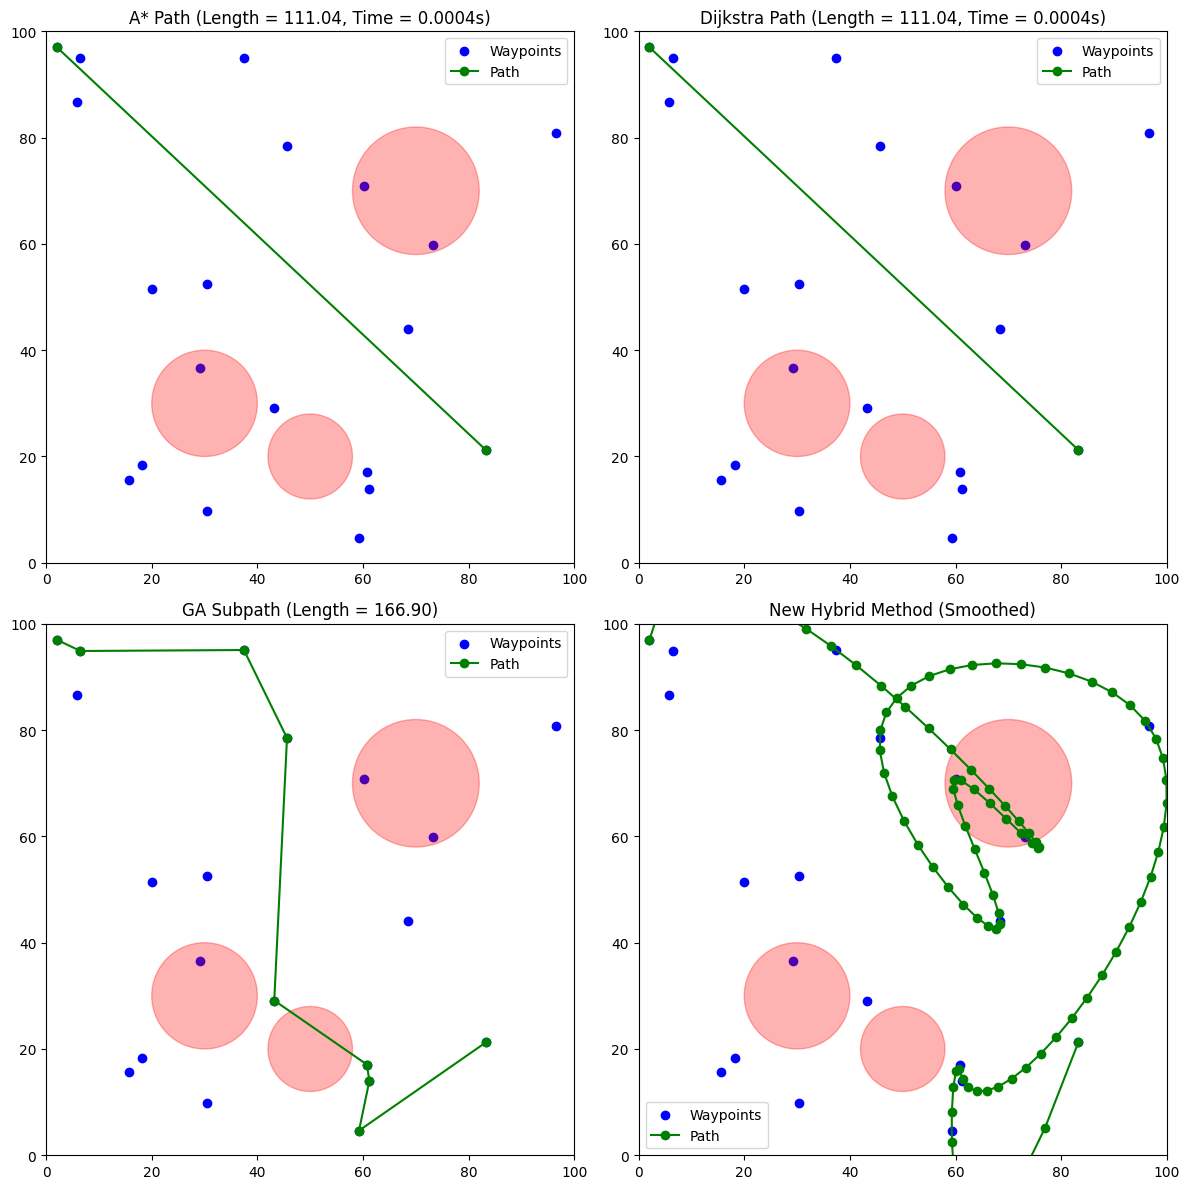

Completed simulation and plotting of all path optimization methods.


In [21]:
# Revised code block to fix the QAOA ordering using cluster information

# Step 4: New Hybrid Method: SOM (simulated with KMeans) + QAOA (simulated quantum ordering) + RL (path smoothing)
# We already computed clustering above, now we restructure the cluster-representative data.

# Create a list of tuples: (cluster_id, representative_index, cluster_center)
cluster_info = []
for i in range(n_clusters):
    indices = np.where(cluster_labels == i)[0]
    rep = min(indices, key=lambda idx: distance(waypoints[idx], cluster_centers[i]))
    cluster_info.append((i, rep, cluster_centers[i]))

# Use simulated QAOA to determine the order of clusters
# We'll use a nearest neighbor heuristic on cluster centers
remaining = cluster_info.copy()
qaoa_order = []
# choose cluster whose center is closest to the starting waypoint
start_cluster_tuple = min(remaining, key=lambda item: distance(waypoints[start], item[2]))
qaoa_order.append(start_cluster_tuple)
remaining.remove(start_cluster_tuple)

while remaining:
    last_cluster = qaoa_order[-1]
    next_cluster_tuple = min(remaining, key=lambda item: distance(last_cluster[2], item[2]))
    qaoa_order.append(next_cluster_tuple)
    remaining.remove(next_cluster_tuple)

# Combine paths: follow clusters in determined order; within each cluster, order by distance from the representative
# For simplicity, we'll sort all waypoints by cluster label order, then within each cluster by distance from cluster center
ordered_waypoints_indices = []
for (cid, rep, center) in qaoa_order:
    cluster_pts = np.where(cluster_labels == cid)[0]
    # sort points in this cluster by distance to the cluster center
    sorted_pts = sorted(cluster_pts, key=lambda idx: distance(waypoints[idx], center))
    ordered_waypoints_indices.extend(sorted_pts)

# Now, we want the hybrid method result only from start to end in the order defined by ordered_waypoints_indices
try:
    start_pos = ordered_waypoints_indices.index(start)
    end_pos = ordered_waypoints_indices.index(end)
    if start_pos <= end_pos:
        hybrid_subpath_indices = ordered_waypoints_indices[start_pos:end_pos+1]
    else:
        hybrid_subpath_indices = ordered_waypoints_indices[end_pos:start_pos+1]
except ValueError:
    # if for some reason start or end isn't in the ordered list, just use the full ordered list
    hybrid_subpath_indices = ordered_waypoints_indices

hybrid_path = [tuple(waypoints[i]) for i in hybrid_subpath_indices]

# Simulated RL adjustment (path smoothing) using spline interpolation if enough points
if len(hybrid_path) >= 3:
    pts = np.array(hybrid_path)
    tck, u = splprep([pts[:,0], pts[:,1]], s=1)
    unew = np.linspace(0, 1, num=100)
    out = splev(unew, tck)
    smooth_path = list(zip(out[0], out[1]))
else:
    smooth_path = hybrid_path

# Plot the results for all methods
fig, axs = plt.subplots(2,2, figsize=(12,12))

plot_environment(axs[0,0], astar_path, 'A* Path (Length = {:.2f}, Time = {:.4f}s)'.format(astar_length, astar_time))
plot_environment(axs[0,1], ndijkstra_path, 'Dijkstra Path (Length = {:.2f}, Time = {:.4f}s)'.format(dijkstra_length, dijkstra_time))
plot_environment(axs[1,0], ga_path, 'GA Subpath (Length = {:.2f})'.format(tsp_fitness(ga_subpath_indices) if ga_subpath_indices else 0))
plot_environment(axs[1,1], smooth_path, 'New Hybrid Method (Smoothed)')

plt.tight_layout()
plt.show()

print('Completed simulation and plotting of all path optimization methods.')